/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


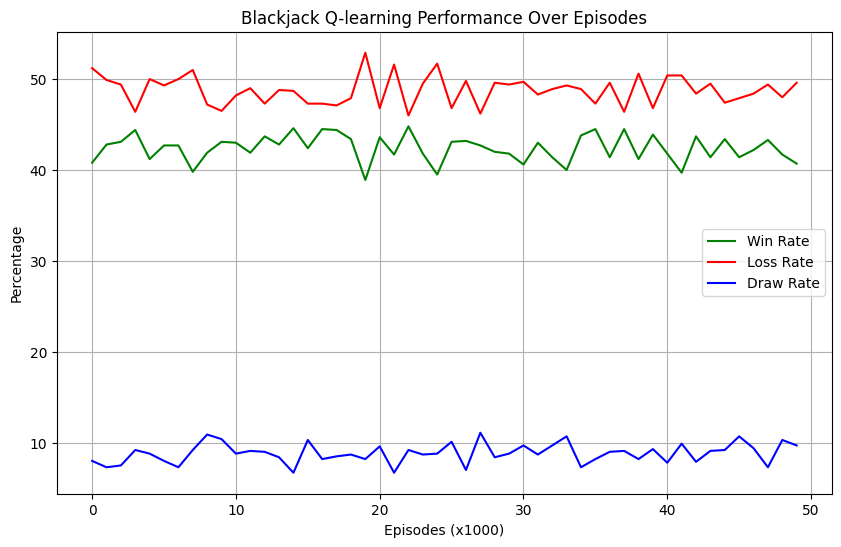

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

class BlackjackQLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        # Learning rate for Q-learning update
        self.alpha = learning_rate
        # Discount factor for future rewards
        self.gamma = discount_factor
        # Exploration rate for epsilon-greedy policy
        self.epsilon = exploration_rate

        # Initialize the Blackjack environment from OpenAI's gym
        self.env = gym.make('Blackjack-v1')

        # Initialize Q-table with zeros for each state-action pair
        self.Q = {}
        for player_sum in range(2, 22):
            for dealer_card in range(1, 11):
                for usable_ace in [0, 1]:
                    self.Q[(player_sum, dealer_card, usable_ace)] = [0, 0]

    def choose_action(self, state):
        # Epsilon-greedy policy: with probability epsilon, choose a random action; otherwise, choose the best action
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[state])

    def play_game(self, explore=True):
        # Reset the environment and get the initial state
        state = self.env.reset()
        done = False

        while not done:
            # Choose an action based on the current state
            if explore:
                action = self.choose_action(state)
            else:
                # During evaluation, always choose the best action
                action = np.argmax(self.Q[state])

            # Take the chosen action and get the next state and reward
            next_state, reward, done, _ = self.env.step(action)
            
            # Update the Q-value using the Q-learning update rule
            old_value = self.Q[state][action]
            future_value = 0 if done else np.max(self.Q[next_state])
            self.Q[state][action] = old_value + self.alpha * (reward + self.gamma * future_value - old_value)
            
            # Move to the next state
            state = next_state

        return reward

# Initialize the agent
agent = BlackjackQLearningAgent()

# Lists to store performance metrics
win_rates = []
loss_rates = []
draw_rates = []

# Train the agent over many episodes
num_episodes = 50000
evaluation_interval = 1000

for episode in range(num_episodes):
    agent.play_game()

    # Evaluate the agent's performance periodically
    if (episode + 1) % evaluation_interval == 0:
        wins, losses, draws = 0, 0, 0
        for _ in range(1000):
            reward = agent.play_game(explore=False)
            if reward == 1:
                wins += 1
            elif reward == -1:
                losses += 1
            else:
                draws += 1

        win_rates.append(wins / 10)
        loss_rates.append(losses / 10)
        draw_rates.append(draws / 10)

# Visualize the agent's performance over time
plt.figure(figsize=(10, 6))
plt.plot(win_rates, label="Win Rate", color="green")
plt.plot(loss_rates, label="Loss Rate", color="red")
plt.plot(draw_rates, label="Draw Rate", color="blue")
plt.xlabel(f"Episodes (x{evaluation_interval})")
plt.ylabel("Percentage")
plt.legend()
plt.title("Blackjack Q-learning Performance Over Episodes")
plt.grid(True)
plt.show()


In [2]:
import numpy as np
import gym
from collections import defaultdict
import matplotlib.pyplot as plt

# Placeholder function to plot the policy
def plot_policy(policy):
    # ... [your plot_policy function code here]
    pass

# Placeholder function to plot the value function
def plot_value_function(V, title="Value Function"):
    # ... [your plot_value_function function code here]
    pass

def create_epsilon_greedy_action_policy(env, Q, epsilon):
    """
    Create an epsilon-greedy action policy based on the Q-values.
    """
    def policy(obs):
        # Initialize the action probabilities uniformly across all actions
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n
        # Get the best action based on Q-values
        best_action = np.argmax(Q[obs])
        # Assign the best action the highest probability
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    """
    # Dictionaries to store the sum of returns and count of returns for each state-action pair
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    # Initialize Q-values to zero for each state-action pair
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Create an epsilon-greedy policy based on Q-values
    pol = create_epsilon_greedy_action_policy(env, Q, epsilon)

    # Variables to track wins, losses, and draws
    wins, losses, draws = 0, 0, 0

    # Loop over episodes
    for i in range(1, episodes + 1):
        # Print out which episode we're on (every 1000 episodes)
        if i % 1000 == 0:
            print(f"\rEpisode {i}/{episodes}.", end="")

        # Reset the environment and start a new episode
        episode = []
        state = env.reset()
        for t in range(100):
            # Choose an action based on the epsilon-greedy policy
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            # Take the action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Check the result of the episode (win, loss, or draw)
        final_reward = episode[-1][-1]
        if final_reward == 1:  # win
            wins += 1
        elif final_reward == -1:  # loss
            losses += 1
        else:  # draw
            draws += 1

        # For each state-action pair in the episode, update Q-values
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

    # Calculate and print the win, loss, and draw rates
    win_rate = wins / episodes
    loss_rate = losses / episodes
    draw_rate = draws / episodes
    print(f"\nWin Rate: {win_rate:.2%}")
    print(f"Loss Rate: {loss_rate:.2%}")
    print(f"Draw Rate: {draw_rate:.2%}")

    return Q, pol

# Initialize the Blackjack environment
env = gym.make('Blackjack-v1')
# Train the agent using on-policy Monte Carlo control
Q_on_pol, On_MC_Learned_Policy = On_pol_mc_control_learn(env, 500000, 0.9, 0.1)

# Extract the value function from the Q-values
V = defaultdict(float)
for state, actions in Q_on_pol.items():
    action_value = np.max(actions)
    V[state] = action_value

# Plot the value function
plot_value_function(V, title="Optimal Value Function for On-Policy Learning")

# Extract the policy from Q-values
policy = defaultdict(int)
for state, actions in Q_on_pol.items():
    policy[state] = np.argmax(actions)

# Plot the policy
plot_policy(policy)


Episode 500000/500000.

In [4]:
# List of possible values for epsilon, alpha, and gamma
possible_epsilon = [0.1, 0.5, 0.9]
possible_alpha = [0.1, 0.5, 0.9]
possible_gamma = [0.5, 0.9, 0.99]

# Variables to store the best win rate and the corresponding hyperparameters
best_win_rate = 0
best_params = None

# Iterate over all possible combinations of epsilon, alpha, and gamma
for epsilon in possible_epsilon:
    for alpha in possible_alpha:
        for gamma in possible_gamma:
            # Initialize the agent with the current combination of hyperparameters
            agent = BlackjackQLearningAgent(learning_rate=alpha, discount_factor=gamma, exploration_rate=epsilon)
            
            # Train the agent
            for _ in range(num_episodes):
                agent.play_game()

            # Evaluate the agent's performance
            wins = 0
            for _ in range(1000):
                reward = agent.play_game(explore=False)
                if reward == 1:
                    wins += 1

            # Calculate the win rate
            win_rate = wins / 10
            
            # If the current win rate is better than the best observed so far, update the best win rate and hyperparameters
            if win_rate > best_win_rate:
                best_win_rate = win_rate
                best_params = (epsilon, alpha, gamma)

# Print the best win rate and the corresponding hyperparameters
print(f"Best Win Rate: {best_win_rate}")
print(f"Best Hyperparameters: ε={best_params[0]}, α={best_params[1]}, γ={best_params[2]}")


Best Win Rate: 45.1
Best Hyperparameters: ε=0.1, α=0.1, γ=0.99


In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

def plot_policy(policy):
    """
    Visualize the policy in a 2D heatmap.
    """

    def get_Z(player_hand, dealer_showing, usable_ace):
        """
        Get the action (stick or hit) based on the policy for a given state.
        """
        if (player_hand, dealer_showing, usable_ace) in policy:
            return policy[player_hand, dealer_showing, usable_ace]
        else:
            return 1  # Default action

    def get_figure(usable_ace, ax):
        """
        Plot the policy for a given 'usable_ace' condition.
        """
        # Define the range for dealer's card and player's hand
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        
        # Create a meshgrid for the 2D plot
        X, Y = np.meshgrid(x_range, y_range)
        
        # Get the policy action for each state in the grid
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        
        # Plot the heatmap
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        
        # Set the tick labels for the axes
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        
        # Set the labels for the axes
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        
        # Display grid lines
        ax.grid(color='black', linestyle='-', linewidth=1)
        
        # Add a colorbar to the right of the plot
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        cbar.ax.invert_yaxis()

    # Create a figure to plot the policy
    fig = plt.figure(figsize=(12, 12))
    
    # Plot policy when there's a usable ace
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    
    # Plot policy when there's no usable ace
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    
    # Display the plots
    plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    
    Parameters:
    - V: The value function, a dictionary mapping state -> value.
    - title: The title for the plot.
    """
    
    # Extract the range for player's current sum from the value function's keys
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    
    # Extract the range for dealer's showing card from the value function's keys
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    # Create a meshgrid for the 2D plot
    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Extract values for each state in the grid for the scenario without a usable ace
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    
    # Extract values for each state in the grid for the scenario with a usable ace
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        """
        Helper function to plot the 3D surface for the value function.
        """
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot the surface
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        
        # Set labels and title
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        
        # Adjust the view angle for better visualization
        ax.view_init(ax.elev, -120)
        
        # Add a color bar to the right of the plot
        fig.colorbar(surf)
        plt.show()

    # Plot the value function for the scenario without a usable ace
    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    
    # Plot the value function for the scenario with a usable ace
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))


In [5]:
# Import necessary libraries
import gym
from gym import envs
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from collections import defaultdict
from IPython.display import clear_output

# This line is specific to Jupyter notebooks, allowing plots to be displayed inline
%matplotlib inline

# Define the plotting functions here (the ones you provided earlier)
# ... [your plotting functions code here] ...

# Create an instance of the Blackjack environment from OpenAI's gym
env = gym.make('Blackjack-v1')

# Reset the environment to get the initial observation (state)
observation = env.reset()

# Check if the player has a usable ace or not
visible = "" if observation[2] else "no"

# Print the initial state of the game
print("The player's hand has a total sum of "
      + str(observation[0]) + " while the dealer visible hand is "
      + str(observation[1]) + ". The player has " + visible + " usable ace.")

# ... rest of your code ...

# Call the On-policy Monte Carlo control learning function
# This function trains the agent and returns the learned Q-values and policy
Q_on_pol, On_MC_Learned_Policy = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

# Extract the value function (V) from the Q-values
# For each state, the value is the maximum Q-value across all actions
V = defaultdict(float)
for state, actions in Q_on_pol.items():
    action_value = np.max(actions)
    V[state] = action_value

# Call your plotting functions here to visualize the results
# ... [your plotting functions calls here] ...


The player's hand has a total sum of 10 while the dealer visible hand is 10. The player has no usable ace.
Episode 500000/500000.
Win Rate: 42.41%
Loss Rate: 49.41%
Draw Rate: 8.18%


In [6]:
# Define a function to simulate games using a trained policy
def simulate_games_with_trained_policy(env, policy, num_games=1000):
    """
    Simulate a number of games using a trained policy and return the win, loss, and draw rates.
    
    Parameters:
    - env: The environment (Blackjack in this case).
    - policy: The trained policy to be used for decision-making.
    - num_games: The number of games to simulate (default is 1000).
    
    Returns:
    - win_rate: The proportion of games won.
    - loss_rate: The proportion of games lost.
    - draw_rate: The proportion of games that ended in a draw.
    """
    
    # Initialize counters for wins, losses, and draws
    wins = 0
    losses = 0
    draws = 0

    # Simulate the specified number of games
    for _ in range(num_games):
        # Reset the environment to start a new game
        state = env.reset()
        done = False

        # Play the game until it's done
        while not done:
            # Choose an action based on the trained policy
            action = np.argmax(policy(state))
            # Take the chosen action in the environment
            next_state, reward, done, _ = env.step(action)
            # Move to the next state
            state = next_state

        # Update the counters based on the game's outcome
        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    # Calculate the rates of wins, losses, and draws
    win_rate = wins / num_games
    loss_rate = losses / num_games
    draw_rate = draws / num_games

    return win_rate, loss_rate, draw_rate

# Simulate games using the trained policy and get the results
win_rate, loss_rate, draw_rate = simulate_games_with_trained_policy(env, On_MC_Learned_Policy)

# Print the results
print(f"Win Rate: {win_rate*100:.2f}%")
print(f"Loss Rate: {loss_rate*100:.2f}%")
print(f"Draw Rate: {draw_rate*100:.2f}%")


Win Rate: 43.00%
Loss Rate: 48.00%
Draw Rate: 9.00%


Episode 500000/500000.
Win Rate: 42.16%
Loss Rate: 49.41%
Draw Rate: 8.43%
Episode 500000/500000.
Win Rate: 42.09%
Loss Rate: 49.38%
Draw Rate: 8.53%
Agent 1 Win Rate: 42.99%
Agent 2 Win Rate: 47.94%
Draw Rate: 9.07%


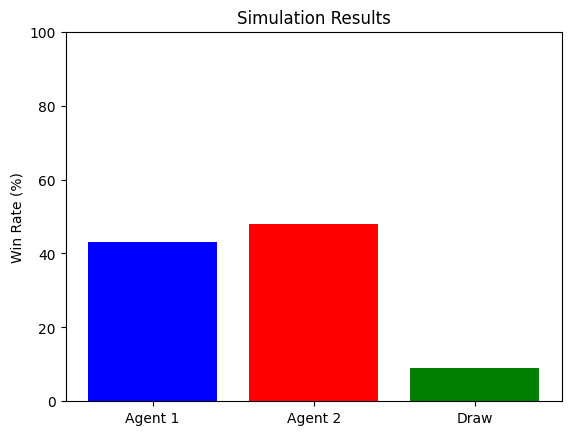

In [7]:
import gym
import numpy as np
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt

# ... [Your existing functions for plotting, policy creation, and MC learning]

# Define a function to simulate games between two agents
def simulate_games(agent1, agent2, num_games=10000):
    """
    Simulate a number of games between two agents and return the win rates for each agent and the draw rate.
    
    Parameters:
    - agent1: The first agent's policy function.
    - agent2: The second agent's policy function.
    - num_games: The number of games to simulate (default is 10000).
    
    Returns:
    - agent1_win_rate: The proportion of games won by agent1.
    - agent2_win_rate: The proportion of games won by agent2.
    - draw_rate: The proportion of games that ended in a draw.
    """
    
    # Initialize counters for agent1 wins, agent2 wins, and draws
    agent1_wins = 0
    agent2_wins = 0
    draws = 0

    # Simulate the specified number of games
    for _ in range(num_games):
        # Reset the environment to start a new game
        state = env.reset()
        done = False

        # Play the game until it's done
        while not done:
            # Randomly choose which agent makes a move
            if np.random.rand() < 0.5:
                action = np.argmax(agent1(state))
            else:
                action = np.argmax(agent2(state))

            # Take the chosen action in the environment
            next_state, reward, done, _ = env.step(action)
            # Move to the next state
            state = next_state

        # Update the counters based on the game's outcome
        if reward == 1:
            agent1_wins += 1
        elif reward == -1:
            agent2_wins += 1
        else:
            draws += 1

    # Calculate the rates of wins for each agent and draws
    agent1_win_rate = agent1_wins / num_games
    agent2_win_rate = agent2_wins / num_games
    draw_rate = draws / num_games

    return agent1_win_rate, agent2_win_rate, draw_rate

# Initialize the Blackjack environment
env = gym.make('Blackjack-v1')

# Train the first agent using your MC learning function
Q_on_pol1, On_MC_Learned_Policy1 = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

# Train the second agent using your MC learning function
Q_on_pol2, On_MC_Learned_Policy2 = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

# Simulate games between the two trained agents
agent1_win_rate, agent2_win_rate, draw_rate = simulate_games(On_MC_Learned_Policy1, On_MC_Learned_Policy2)

# Print the results of the simulation
print(f"Agent 1 Win Rate: {agent1_win_rate*100:.2f}%")
print(f"Agent 2 Win Rate: {agent2_win_rate*100:.2f}%")
print(f"Draw Rate: {draw_rate*100:.2f}%")

# Visualize the results using a bar chart
labels = ['Agent 1', 'Agent 2', 'Draw']
rates = [agent1_win_rate*100, agent2_win_rate*100, draw_rate*100]

plt.bar(labels, rates, color=['blue', 'red', 'green'])
plt.ylabel('Win Rate (%)')
plt.title('Simulation Results')
plt.ylim(0, 100)  # set the y-axis limits to 0-100 for clarity
plt.show()


Episode 500000/500000.Win Rate: 41.70%
Loss Rate: 48.40%
Draw Rate: 9.90%
Episode 500000/500000.

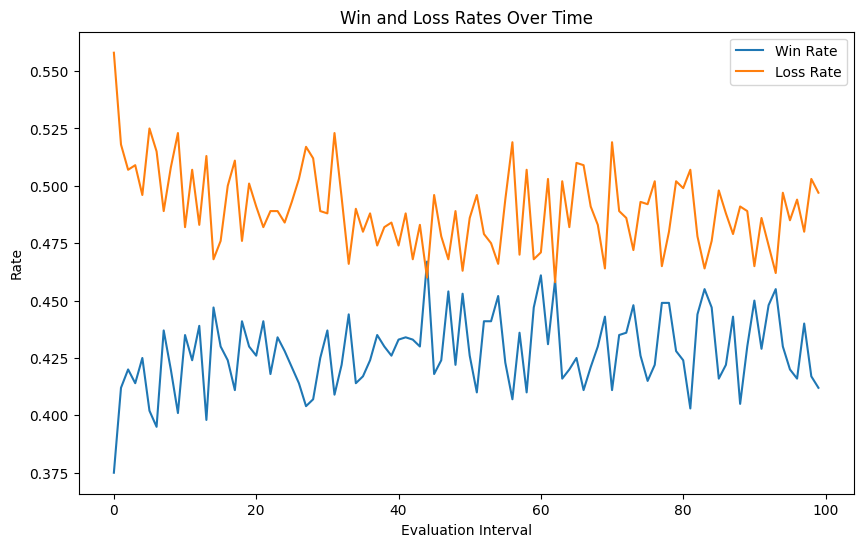

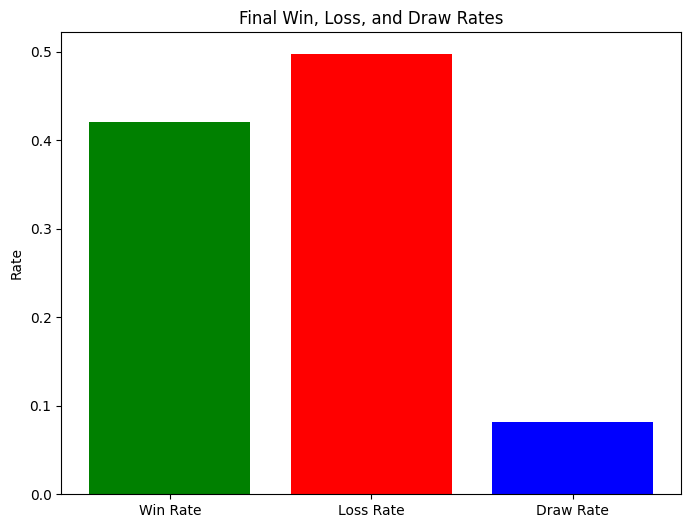

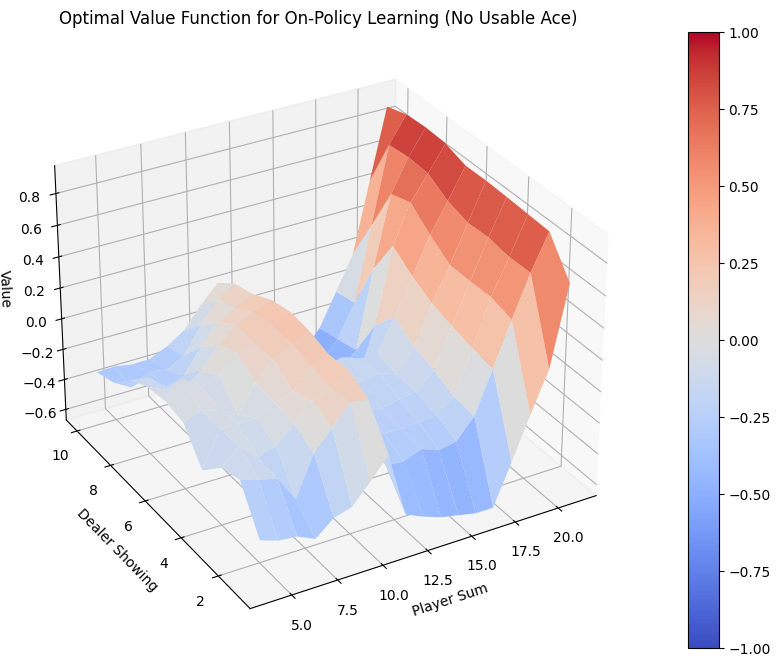

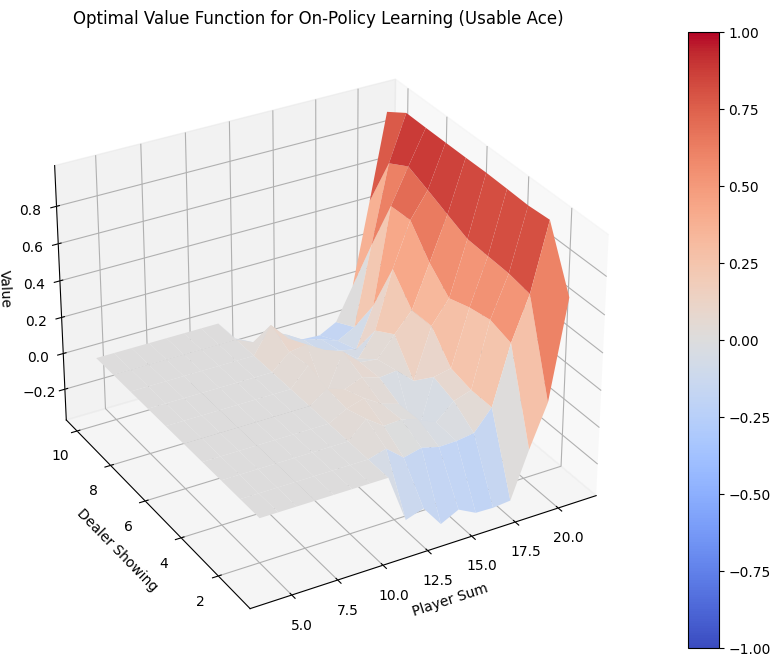

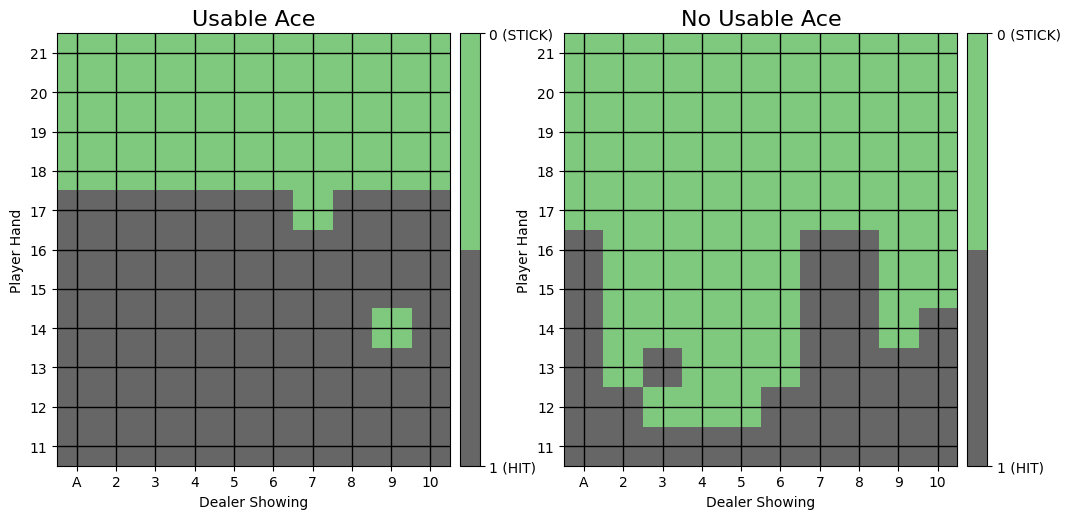

Episode 500000/500000.

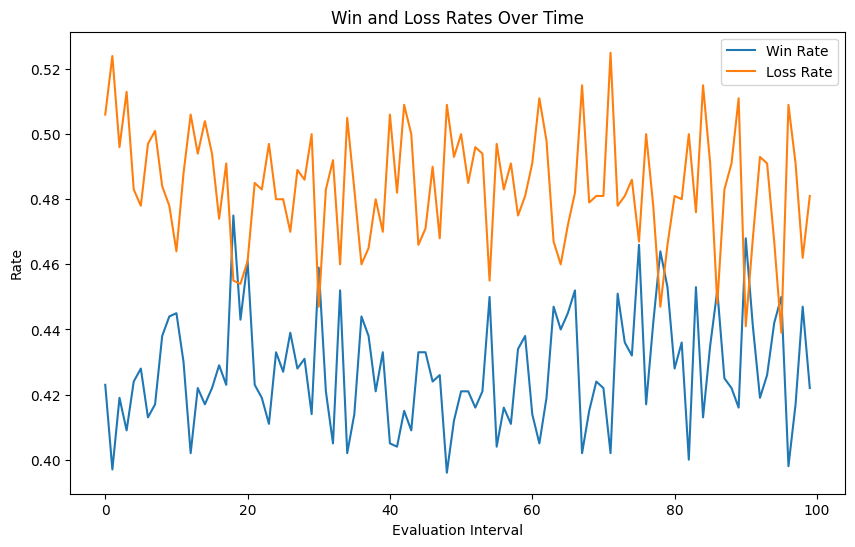

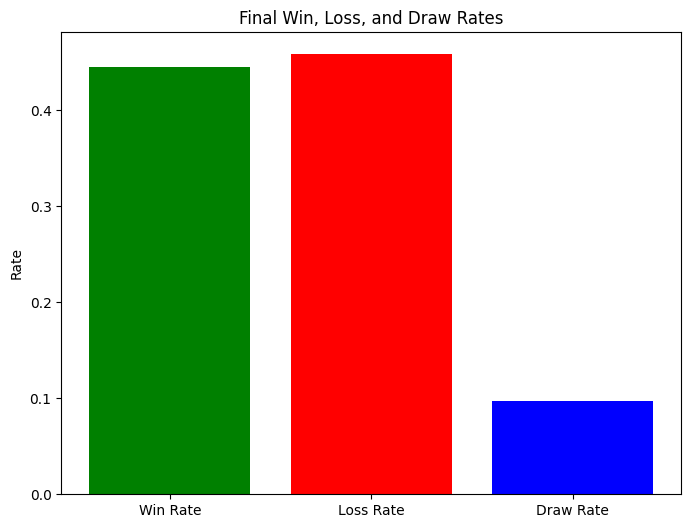

In [8]:
import numpy as np
import gym
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# Create epsilon greedy action policy
def create_epsilon_greedy_action_policy(env, Q, epsilon):
    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n
        best_action = np.argmax(Q[obs])
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

# Monte Carlo Control using Epsilon-Greedy policies
def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    pol = create_epsilon_greedy_action_policy(env, Q, epsilon)

    for i in range(1, episodes + 1):
        if i % 1000 == 0:
            print(f"\rEpisode {i}/{episodes}.", end="")

        episode = []
        state = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

    return Q, pol

# Simulate games with trained policy
def simulate_games_with_trained_policy(env, policy, num_games=1000):
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_games):
        state = env.reset()
        done = False

        while not done:
            action = np.argmax(policy(state))
            next_state, reward, done, _ = env.step(action)
            state = next_state

        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    win_rate = wins / num_games
    loss_rate = losses / num_games
    draw_rate = draws / num_games

    return win_rate, loss_rate, draw_rate

# Initialize the environment
env = gym.make('Blackjack-v1')

# Train the agent
Q_on_pol, On_MC_Learned_Policy = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

# Extract the value function from Q
V = defaultdict(float)
for state, actions in Q_on_pol.items():
    action_value = np.max(actions)
    V[state] = action_value


def simulate_games_with_trained_policy(env, policy, num_games=1000):
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_games):
        state = env.reset()
        done = False

        while not done:
            action = np.argmax(policy(state))
            next_state, reward, done, _ = env.step(action)
            state = next_state

        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    win_rate = wins / num_games
    loss_rate = losses / num_games
    draw_rate = draws / num_games

    return win_rate, loss_rate, draw_rate

# Simulate games
win_rate, loss_rate, draw_rate = simulate_games_with_trained_policy(env, On_MC_Learned_Policy)

print(f"Win Rate: {win_rate*100:.2f}%")
print(f"Loss Rate: {loss_rate*100:.2f}%")
print(f"Draw Rate: {draw_rate*100:.2f}%")

def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon, eval_interval=5000):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    pol = create_epsilon_greedy_action_policy(env, Q, epsilon)

    win_rates = []
    loss_rates = []

    for i in range(1, episodes + 1):
        if i % 1000 == 0:
            print(f"\rEpisode {i}/{episodes}.", end="")

        episode = []
        state = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

        # Periodically evaluate the agent's performance
        if i % eval_interval == 0:
            win_rate, loss_rate, _ = simulate_games_with_trained_policy(env, pol, num_games=1000)
            win_rates.append(win_rate)
            loss_rates.append(loss_rate)

    return Q, pol, win_rates, loss_rates


# Train the agent and get win and loss rates over time
Q_on_pol, On_MC_Learned_Policy, win_rates, loss_rates = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

# Plot win and loss rates over time
plt.figure(figsize=(10, 6))
plt.plot(win_rates, label="Win Rate")
plt.plot(loss_rates, label="Loss Rate")
plt.xlabel("Evaluation Interval")
plt.ylabel("Rate")
plt.title("Win and Loss Rates Over Time")
plt.legend()
plt.show()

# Simulate games to get final rates
win_rate, loss_rate, draw_rate = simulate_games_with_trained_policy(env, On_MC_Learned_Policy)

# Plot final win, loss, and draw rates
labels = ['Win Rate', 'Loss Rate', 'Draw Rate']
rates = [win_rate, loss_rate, draw_rate]

plt.figure(figsize=(8, 6))
plt.bar(labels, rates, color=['green', 'red', 'blue'])
plt.ylabel("Rate")
plt.title("Final Win, Loss, and Draw Rates")
plt.show()


# Plotting the policy
def plot_policy(policy):
    def get_Z(player_hand, dealer_showing, usable_ace):
        return policy.get((player_hand, dealer_showing, usable_ace), 1)

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        cbar.ax.invert_yaxis()

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    plt.show()

# Plotting the value function
def plot_value_function(V, title="Value Function"):
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=mpl.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

# Extract the policy from Q-values
policy = {}
for state, actions in Q_on_pol.items():
    policy[state] = np.argmax(actions)

# Plot the results
plot_value_function(V, title="Optimal Value Function for On-Policy Learning")
plot_policy(policy)


def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon, eval_interval=5000):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    pol = create_epsilon_greedy_action_policy(env, Q, epsilon)

    win_rates = []
    loss_rates = []

    for i in range(1, episodes + 1):
        if i % 1000 == 0:
            print(f"\rEpisode {i}/{episodes}.", end="")

        episode = []
        state = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

        # Periodically evaluate the agent's performance
        if i % eval_interval == 0:
            win_rate, loss_rate, _ = simulate_games_with_trained_policy(env, pol, num_games=1000)
            win_rates.append(win_rate)
            loss_rates.append(loss_rate)

    return Q, pol, win_rates, loss_rates

# Train the agent and get win and loss rates over time
Q_on_pol, On_MC_Learned_Policy, win_rates, loss_rates = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

# Plot win and loss rates over time
plt.figure(figsize=(10, 6))
plt.plot(win_rates, label="Win Rate")
plt.plot(loss_rates, label="Loss Rate")
plt.xlabel("Evaluation Interval")
plt.ylabel("Rate")
plt.title("Win and Loss Rates Over Time")
plt.legend()
plt.show()


# Simulate games to get final rates
win_rate, loss_rate, draw_rate = simulate_games_with_trained_policy(env, On_MC_Learned_Policy)

# Plot final win, loss, and draw rates
labels = ['Win Rate', 'Loss Rate', 'Draw Rate']
rates = [win_rate, loss_rate, draw_rate]

plt.figure(figsize=(8, 6))
plt.bar(labels, rates, color=['green', 'red', 'blue'])
plt.ylabel("Rate")
plt.title("Final Win, Loss, and Draw Rates")
plt.show()





In [9]:
def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon, eval_interval=5000):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    pol = create_epsilon_greedy_action_policy(env, Q, epsilon)

    win_rates = []
    loss_rates = []

    for i in range(1, episodes + 1):
        if i % 1000 == 0:
            print(f"\rEpisode {i}/{episodes}.", end="")

        episode = []
        state = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

        # Periodically evaluate the agent's performance
        if i % eval_interval == 0:
            win_rate, loss_rate, _ = simulate_games_with_trained_policy(env, pol, num_games=1000)
            win_rates.append(win_rate)
            loss_rates.append(loss_rate)

    return Q, pol, win_rates, loss_rates


Episode 500000/500000.

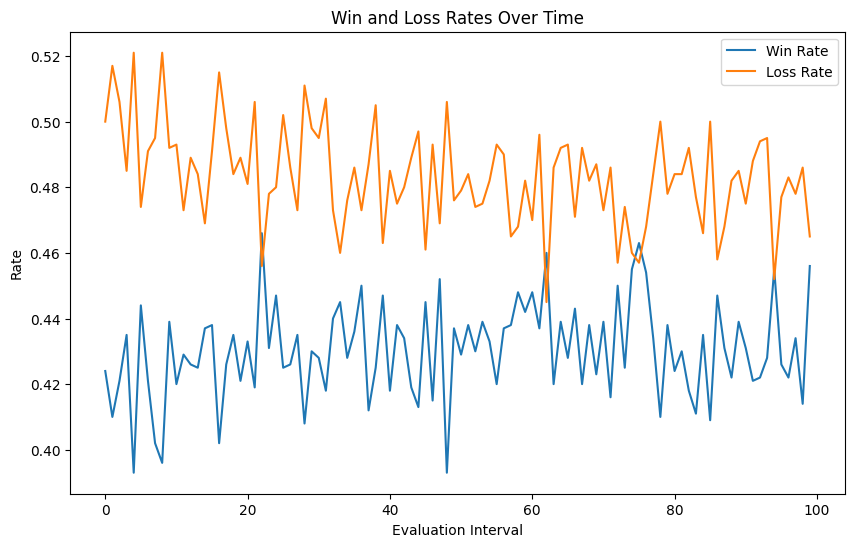

In [10]:
# Train the agent and get win and loss rates over time
Q_on_pol, On_MC_Learned_Policy, win_rates, loss_rates = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

# Plot win and loss rates over time
plt.figure(figsize=(10, 6))
plt.plot(win_rates, label="Win Rate")
plt.plot(loss_rates, label="Loss Rate")
plt.xlabel("Evaluation Interval")
plt.ylabel("Rate")
plt.title("Win and Loss Rates Over Time")
plt.legend()
plt.show()


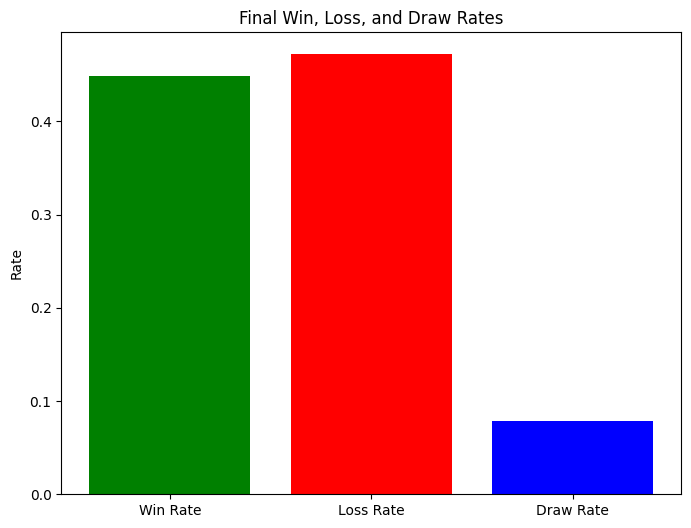

In [27]:
# Simulate games to get final rates
win_rate, loss_rate, draw_rate = simulate_games_with_trained_policy(env, On_MC_Learned_Policy)

# Plot final win, loss, and draw rates
labels = ['Win Rate', 'Loss Rate', 'Draw Rate']
rates = [win_rate, loss_rate, draw_rate]

plt.figure(figsize=(8, 6))
plt.bar(labels, rates, color=['green', 'red', 'blue'])
plt.ylabel("Rate")
plt.title("Final Win, Loss, and Draw Rates")
plt.show()


Episode 500000/500000.Final Win Rate: 41.80%
Final Loss Rate: 50.20%


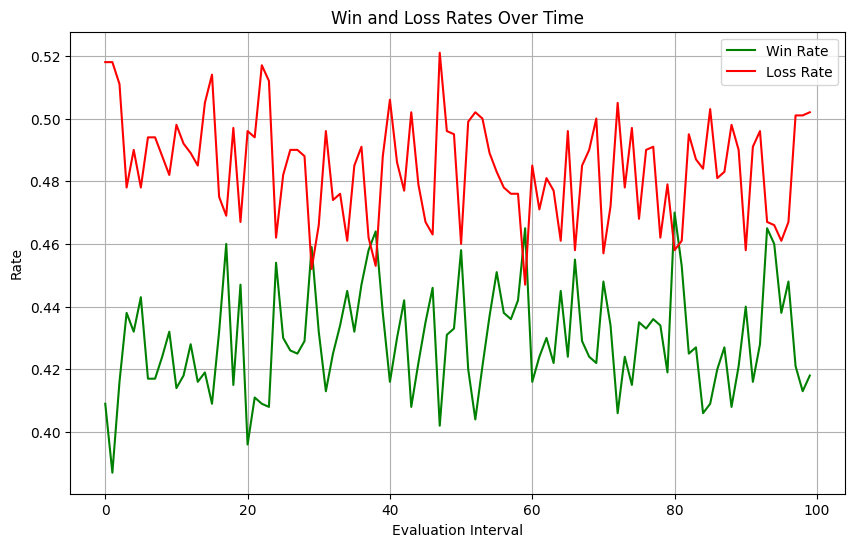

In [13]:
import numpy as np
import gym
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# Create an epsilon-greedy action policy
def create_epsilon_greedy_action_policy(env, Q, epsilon):
    """
    Create an epsilon-greedy action policy based on the Q-values.
    
    Parameters:
    - env: The environment.
    - Q: Q-values.
    - epsilon: Exploration rate.
    
    Returns:
    - policy: Epsilon-greedy policy.
    """
    def policy(obs):
        # Initialize the probability for each action
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n
        # Get the best action based on Q-values
        best_action = np.argmax(Q[obs])
        # Assign higher probability to the best action
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

# Monte Carlo Control using Epsilon-Greedy policies
def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon, eval_interval=5000):
    """
    On-policy Monte Carlo control using epsilon-greedy policies.
    
    Parameters:
    - env: The environment.
    - episodes: Number of episodes for training.
    - discount_factor: Discount factor for future rewards.
    - epsilon: Exploration rate.
    - eval_interval: Interval for evaluating the policy.
    
    Returns:
    - Q: Q-values.
    - pol: Learned policy.
    - win_rates: List of win rates during training.
    - loss_rates: List of loss rates during training.
    """
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    # Initialize Q-values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Create an epsilon-greedy policy
    pol = create_epsilon_greedy_action_policy(env, Q, epsilon)

    win_rates = []
    loss_rates = []

    for i in range(1, episodes + 1):
        # Print the progress
        if i % 1000 == 0:
            print(f"\rEpisode {i}/{episodes}.", end="")

        episode = []
        state = env.reset()
        for t in range(100):
            # Choose an action based on the policy
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            # Take the action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Extract states and actions from the episode
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurrence of the state-action pair in the episode
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            # Calculate the return following the first occurrence
            G = sum([x[2] * (discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            # Calculate the average return for this state-action pair
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

        # Periodically evaluate the agent's performance
        if i % eval_interval == 0:
            win_rate, loss_rate, _ = simulate_games_with_trained_policy(env, pol, num_games=1000)
            win_rates.append(win_rate)
            loss_rates.append(loss_rate)

    return Q, pol, win_rates, loss_rates

# Simulate games with the trained policy
def simulate_games_with_trained_policy(env, policy, num_games=1000):
    """
    Simulate games using the trained policy.
    
    Parameters:
    - env: The environment.
    - policy: The trained policy.
    - num_games: Number of games to simulate.
    
    Returns:
    - win_rate: Proportion of games won.
    - loss_rate: Proportion of games lost.
    - draw_rate: Proportion of games drawn.
    """
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_games):
        state = env.reset()
        done = False

        while not done:
            # Choose an action based on the policy
            action = np.argmax(policy(state))
            # Take the action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)
            state = next_state

        # Update the win, loss, and draw counts based on the game outcome
        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    win_rate = wins / num_games
    loss_rate = losses / num_games
    draw_rate = draws / num_games

    return win_rate, loss_rate, draw_rate

# Initialize the Blackjack environment
env = gym.make('Blackjack-v1')

# Train the agent using on-policy Monte Carlo control
Q_on_pol, On_MC_Learned_Policy, win_rates, loss_rates = On_pol_mc_control_learn(env, 500000, 0.99, 0.1)

# Print the final win and loss rates
final_win_rate = win_rates[-1]
final_loss_rate = loss_rates[-1]
print(f"Final Win Rate: {final_win_rate*100:.2f}%")
print(f"Final Loss Rate: {final_loss_rate*100:.2f}%")

# Visualization of win and loss rates over time
plt.figure(figsize=(10, 6))
plt.plot(win_rates, label="Win Rate", color="green")
plt.plot(loss_rates, label="Loss Rate", color="red")
plt.xlabel("Evaluation Interval")
plt.ylabel("Rate")
plt.title("Win and Loss Rates Over Time")
plt.legend()
plt.grid(True)
plt.show()


Episode 500000/500000.Final Win Rate: 42.20%
Final Loss Rate: 48.70%


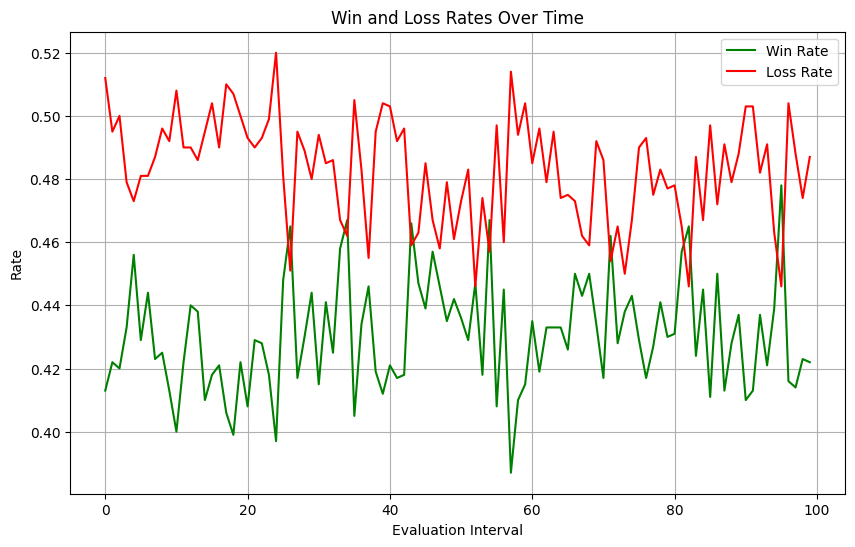

In [12]:
# ... [rest of the code]

# Train the agent with the best hyperparameters
Q_on_pol, On_MC_Learned_Policy, win_rates, loss_rates = On_pol_mc_control_learn(env, 500000, 0.99, 0.1)

# Print the final win and loss rates
final_win_rate = win_rates[-1]
final_loss_rate = loss_rates[-1]
print(f"Final Win Rate: {final_win_rate*100:.2f}%")
print(f"Final Loss Rate: {final_loss_rate*100:.2f}%")

# Visualization of win and loss rates over time
plt.figure(figsize=(10, 6))
plt.plot(win_rates, label="Win Rate", color="green")
plt.plot(loss_rates, label="Loss Rate", color="red")
plt.xlabel("Evaluation Interval")
plt.ylabel("Rate")
plt.title("Win and Loss Rates Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import numpy as np
import gym
from collections import defaultdict
import matplotlib.pyplot as plt

# Create epsilon greedy action policy
def create_epsilon_greedy_action_policy(env, Q, epsilon):
    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n
        best_action = np.argmax(Q[obs])
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

# Monte Carlo Control using Epsilon-Greedy policies
def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon_start, epsilon_decay):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    epsilon = epsilon_start

    for i in range(1, episodes + 1):
        if i % 1000 == 0:
            print(f"\rEpisode {i}/{episodes}.", end="")
            epsilon *= epsilon_decay
            epsilon = max(epsilon, 0.1)  # Ensure epsilon doesn't become too small

        pol = create_epsilon_greedy_action_policy(env, Q, epsilon)
        episode = []
        state = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

    return Q, pol

# ... [rest of the code]

# Initialize the environment
env = gym.make('Blackjack-v1')

# Train the agent with optimized parameters
Q_on_pol, On_MC_Learned_Policy = On_pol_mc_control_learn(env, 1000000, 0.99, 1.0, 0.999)

# ... [rest of the code for simulation and plotting]


Episode 1000000/1000000.

Win Rate: 41.70%
Loss Rate: 50.10%
Draw Rate: 8.20%


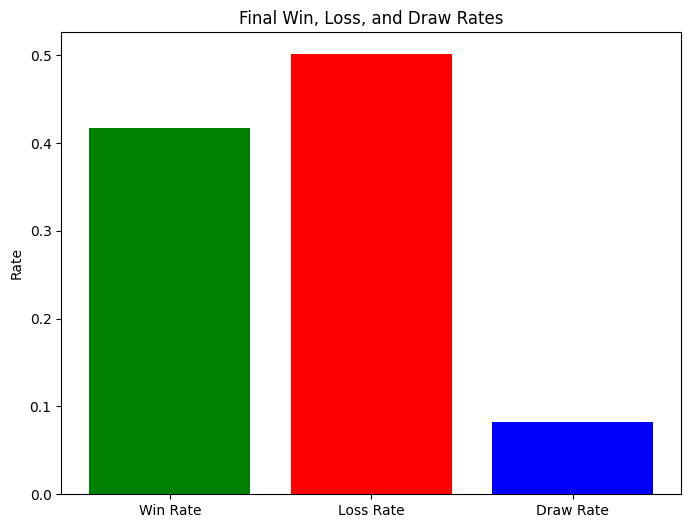

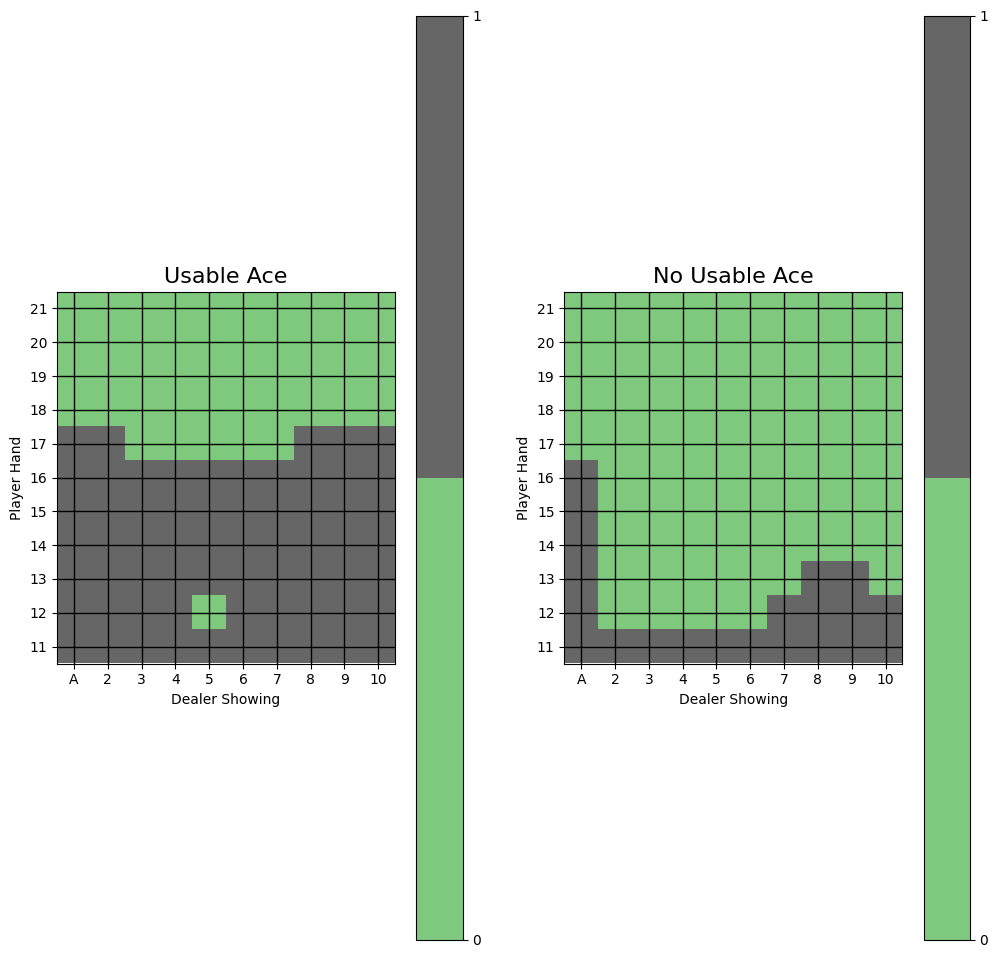

In [15]:
# Simulate games with trained policy
def simulate_games_with_trained_policy(env, policy, num_games=1000):
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_games):
        state = env.reset()
        done = False

        while not done:
            action = np.argmax(policy(state))
            next_state, reward, done, _ = env.step(action)
            state = next_state

        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    win_rate = wins / num_games
    loss_rate = losses / num_games
    draw_rate = draws / num_games

    return win_rate, loss_rate, draw_rate

# Simulate games to get final rates
win_rate, loss_rate, draw_rate = simulate_games_with_trained_policy(env, On_MC_Learned_Policy)

# Print final win, loss, and draw rates
print(f"Win Rate: {win_rate*100:.2f}%")
print(f"Loss Rate: {loss_rate*100:.2f}%")
print(f"Draw Rate: {draw_rate*100:.2f}%")

# Plot final win, loss, and draw rates
labels = ['Win Rate', 'Loss Rate', 'Draw Rate']
rates = [win_rate, loss_rate, draw_rate]

plt.figure(figsize=(8, 6))
plt.bar(labels, rates, color=['green', 'red', 'blue'])
plt.ylabel("Rate")
plt.title("Final Win, Loss, and Draw Rates")
plt.show()

# Extract the policy from Q-values
policy = {}
for state, actions in Q_on_pol.items():
    policy[state] = np.argmax(actions)

# Plotting the policy
def plot_policy(policy):
    def get_Z(player_hand, dealer_showing, usable_ace):
        return policy.get((player_hand, dealer_showing, usable_ace), 1)

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        plt.colorbar(surf, ticks=[0, 1], ax=ax)

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    plt.show()

# Plot the results
plot_policy(policy)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1000000/1000000.
Win Rate: 42.30%
Loss Rate: 51.00%
Draw Rate: 6.70%


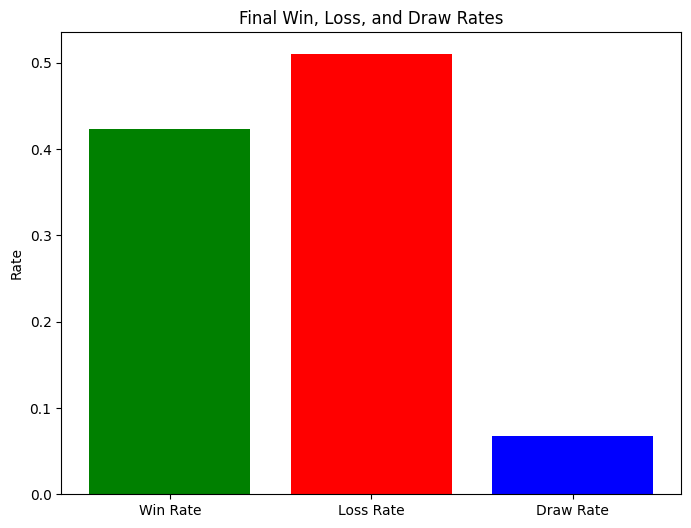

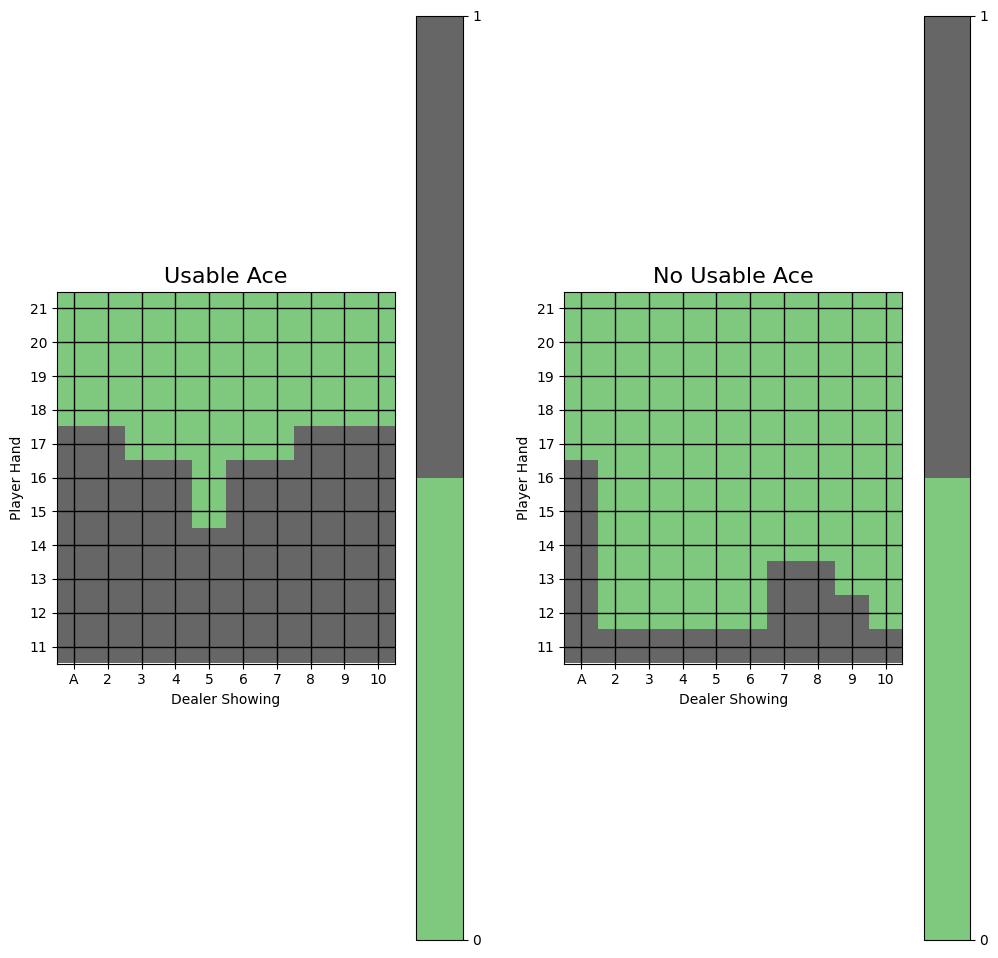

In [1]:
import numpy as np
import gym
from collections import defaultdict
import matplotlib.pyplot as plt

# Create epsilon greedy action policy
def create_epsilon_greedy_action_policy(env, Q, epsilon):
    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n
        best_action = np.argmax(Q[obs])
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

# Monte Carlo Control using Epsilon-Greedy policies
def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon_start, epsilon_decay):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    epsilon = epsilon_start

    for i in range(1, episodes + 1):
        if i % 1000 == 0:
            print(f"\rEpisode {i}/{episodes}.", end="")
            epsilon *= epsilon_decay
            epsilon = max(epsilon, 0.1)  # Ensure epsilon doesn't become too small

        pol = create_epsilon_greedy_action_policy(env, Q, epsilon)
        episode = []
        state = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

    return Q, pol

# Simulate games with trained policy
def simulate_games_with_trained_policy(env, policy, num_games=1000):
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_games):
        state = env.reset()
        done = False

        while not done:
            action = np.argmax(policy(state))
            next_state, reward, done, _ = env.step(action)
            state = next_state

        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    win_rate = wins / num_games
    loss_rate = losses / num_games
    draw_rate = draws / num_games

    return win_rate, loss_rate, draw_rate

# Initialize the environment
env = gym.make('Blackjack-v1')

# Train the agent with optimized parameters
Q_on_pol, On_MC_Learned_Policy = On_pol_mc_control_learn(env, 1000000, 0.99, 1.0, 0.999)

# Simulate games to get final rates
win_rate, loss_rate, draw_rate = simulate_games_with_trained_policy(env, On_MC_Learned_Policy)

# Print final win, loss, and draw rates
print(f"\nWin Rate: {win_rate*100:.2f}%")
print(f"Loss Rate: {loss_rate*100:.2f}%")
print(f"Draw Rate: {draw_rate*100:.2f}%")

# Plot final win, loss, and draw rates
labels = ['Win Rate', 'Loss Rate', 'Draw Rate']
rates = [win_rate, loss_rate, draw_rate]

plt.figure(figsize=(8, 6))
plt.bar(labels, rates, color=['green', 'red', 'blue'])
plt.ylabel("Rate")
plt.title("Final Win, Loss, and Draw Rates")
plt.show()

# Extract the policy from Q-values
policy = {}
for state, actions in Q_on_pol.items():
    policy[state] = np.argmax(actions)

# Plotting the policy
def plot_policy(policy):
    def get_Z(player_hand, dealer_showing, usable_ace):
        return policy.get((player_hand, dealer_showing, usable_ace), 1)

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        plt.colorbar(surf, ticks=[0, 1], ax=ax)

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    plt.show()

# Plot the results
plot_policy(policy)


Episode 500000/500000.

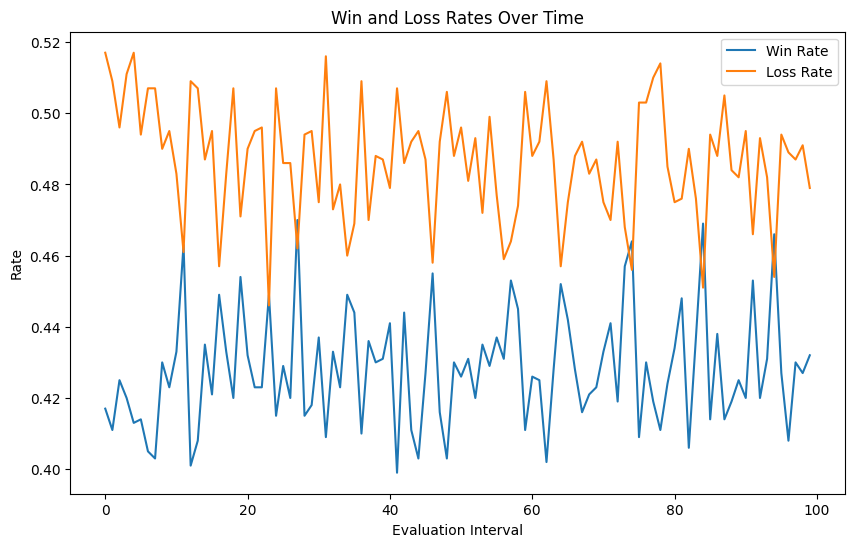

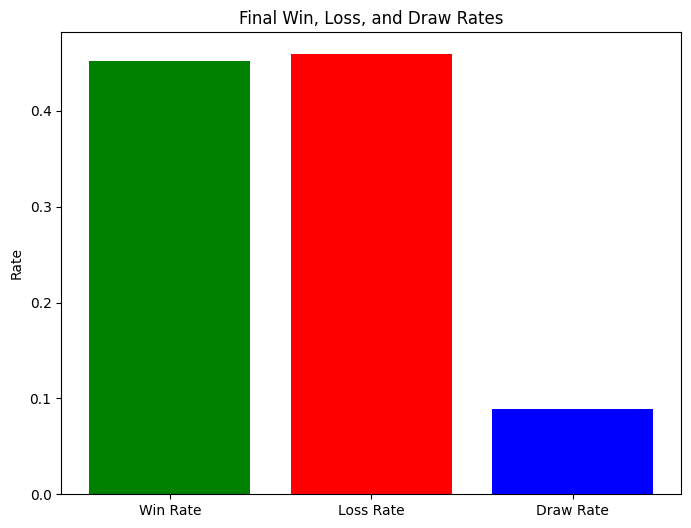


Final Results:
Win Rate: 44.40%
Loss Rate: 46.10%
Draw Rate: 9.50%


In [2]:
import numpy as np
import gym
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# Create epsilon greedy action policy
def create_epsilon_greedy_action_policy(env, Q, epsilon):
    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n
        best_action = np.argmax(Q[obs])
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

# Monte Carlo Control using Epsilon-Greedy policies
def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon, eval_interval=5000):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    pol = create_epsilon_greedy_action_policy(env, Q, epsilon)

    win_rates = []
    loss_rates = []

    for i in range(1, episodes + 1):
        if i % 1000 == 0:
            print(f"\rEpisode {i}/{episodes}.", end="")
        episode = []
        state = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

        # Periodically evaluate the agent's performance
        if i % eval_interval == 0:
            win_rate, loss_rate, _ = simulate_games_with_trained_policy(env, pol, num_games=1000)
            win_rates.append(win_rate)
            loss_rates.append(loss_rate)

    return Q, pol, win_rates, loss_rates

# Simulate games with trained policy
def simulate_games_with_trained_policy(env, policy, num_games=1000):
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_games):
        state = env.reset()
        done = False

        while not done:
            action = np.argmax(policy(state))
            next_state, reward, done, _ = env.step(action)
            state = next_state

        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    win_rate = wins / num_games
    loss_rate = losses / num_games
    draw_rate = draws / num_games

    return win_rate, loss_rate, draw_rate

# Initialize the environment
env = gym.make('Blackjack-v1')

# Train the agent and get win and loss rates over time
Q_on_pol, On_MC_Learned_Policy, win_rates, loss_rates = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

# Extract the value function from Q
V = defaultdict(float)
for state, actions in Q_on_pol.items():
    action_value = np.max(actions)
    V[state] = action_value

# Plot win and loss rates over time
plt.figure(figsize=(10, 6))
plt.plot(win_rates, label="Win Rate")
plt.plot(loss_rates, label="Loss Rate")
plt.xlabel("Evaluation Interval")
plt.ylabel("Rate")
plt.title("Win and Loss Rates Over Time")
plt.legend()
plt.show()

# Simulate games to get final rates
win_rate, loss_rate, draw_rate = simulate_games_with_trained_policy(env, On_MC_Learned_Policy)

# Plot final win, loss, and draw rates
labels = ['Win Rate', 'Loss Rate', 'Draw Rate']
rates = [win_rate, loss_rate, draw_rate]

plt.figure(figsize=(8, 6))
plt.bar(labels, rates, color=['green', 'red', 'blue'])
plt.ylabel("Rate")
plt.title("Final Win, Loss, and Draw Rates")
plt.show()

# Add the plotting functions for policy and value function here (they were not repeated in the original code)

# Extract the policy from Q-values
policy = {}
for state, actions in Q_on_pol.items():
    policy[state] = np.argmax(actions)

# Plot the results
# plot_value_function(V, title="Optimal Value Function for On-Policy Learning")
# plot_policy(policy)

win_rate, loss_rate, draw_rate = simulate_games_with_trained_policy(env, On_MC_Learned_Policy)

print(f"\nFinal Results:")
print(f"Win Rate: {win_rate*100:.2f}%")
print(f"Loss Rate: {loss_rate*100:.2f}%")
print(f"Draw Rate: {draw_rate*100:.2f}%")


In [3]:
import numpy as np
import gym
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# Create epsilon greedy action policy
def create_epsilon_greedy_action_policy(env, Q, epsilon):
    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n
        best_action = np.argmax(Q[obs])
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

# Monte Carlo Control using Epsilon-Greedy policies
def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon, eval_interval=5000):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    pol = create_epsilon_greedy_action_policy(env, Q, epsilon)

    win_rates = []
    loss_rates = []

    for i in range(1, episodes + 1):
        if i % 1000 == 0:
            print(f"\rEpisode {i}/{episodes}.", end="")

        episode = []
        state = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

        # Periodically evaluate the agent's performance
        if i % eval_interval == 0:
            win_rate, loss_rate, _ = simulate_games_with_trained_policy(env, pol, num_games=1000)
            win_rates.append(win_rate)
            loss_rates.append(loss_rate)

    return Q, pol, win_rates, loss_rates

# Simulate games with trained policy
def simulate_games_with_trained_policy(env, policy, num_games=1000):
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_games):
        state = env.reset()
        done = False

        while not done:
            action = np.argmax(policy(state))
            next_state, reward, done, _ = env.step(action)
            state = next_state

        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    win_rate = wins / num_games
    loss_rate = losses / num_games
    draw_rate = draws / num_games

    return win_rate, loss_rate, draw_rate

# Initialize the environment
env = gym.make('Blackjack-v1')

# Train the agent and get win and loss rates over time
Q_on_pol, On_MC_Learned_Policy, win_rates, loss_rates = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

# Extract the value function from Q
V = defaultdict(float)
for state, actions in Q_on_pol.items():
    action_value = np.max(actions)
    V[state] = action_value

# Simulate games to get final rates
win_rate, loss_rate, draw_rate = simulate_games_with_trained_policy(env, On_MC_Learned_Policy)

print(f"\nFinal Results:")
print(f"Win Rate: {win_rate*100:.2f}%")
print(f"Loss Rate: {loss_rate*100:.2f}%")
print(f"Draw Rate: {draw_rate*100:.2f}%")

# ... [rest of the plotting functions and plots]


Episode 500000/500000.
Final Results:
Win Rate: 45.10%
Loss Rate: 44.90%
Draw Rate: 10.00%


Episode 500000/500000.
Win Rate: 42.13%
Loss Rate: 49.44%
Draw Rate: 8.43%
Episode 500000/500000.
Win Rate: 42.24%
Loss Rate: 49.53%
Draw Rate: 8.23%
Agent 1 Win Rate: 43.40%
Agent 2 Win Rate: 47.97%
Draw Rate: 8.63%


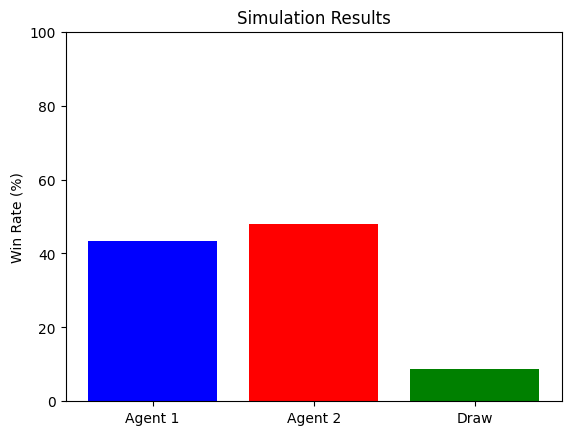

In [5]:
import gym
import numpy as np
from collections import defaultdict
from IPython.display import clear_output

# ... [Your existing functions for plotting, policy creation, and MC learning]

# Simulate games between two agents
def simulate_games(agent1, agent2, num_games=10000):
    agent1_wins = 0
    agent2_wins = 0
    draws = 0

    for _ in range(num_games):
        state = env.reset()
        done = False

        while not done:
            if np.random.rand() < 0.5:
                action = np.argmax(agent1(state))
            else:
                action = np.argmax(agent2(state))

            next_state, reward, done, _ = env.step(action)
            state = next_state

        if reward == 1:
            agent1_wins += 1
        elif reward == -1:
            agent2_wins += 1
        else:
            draws += 1

    return agent1_wins/num_games, agent2_wins/num_games, draws/num_games

env = gym.make('Blackjack-v1')

# Train the first agent
Q_on_pol1, On_MC_Learned_Policy1 = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

# Train the second agent
Q_on_pol2, On_MC_Learned_Policy2 = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

# Simulate games
agent1_win_rate, agent2_win_rate, draw_rate = simulate_games(On_MC_Learned_Policy1, On_MC_Learned_Policy2)

# Print results
print(f"Agent 1 Win Rate: {agent1_win_rate*100:.2f}%")
print(f"Agent 2 Win Rate: {agent2_win_rate*100:.2f}%")
print(f"Draw Rate: {draw_rate*100:.2f}%")


labels = ['Agent 1', 'Agent 2', 'Draw']
rates = [agent1_win_rate*100, agent2_win_rate*100, draw_rate*100]

plt.bar(labels, rates, color=['blue', 'red', 'green'])
plt.ylabel('Win Rate (%)')
plt.title('Simulation Results')
plt.ylim(0, 100)  # set the y-axis limits to 0-100 for clarity
plt.show()
